In [6]:
import pandas as pd 
import numpy as np
from IPython.display import Video, Image
path_data = 'input/BDB2022-plots/'

<div style="font-family:verdana; word-spacing:1.5px;">
  <p style="text-align:center;">"There is no defense against a perfect pass. I can throw the perfect pass." -Dan Marino</p>
    <p>A defender might say something similar to Dan the Man:</p>
   <p style="text-align:center;">"There is no throw when I make the perfect coverage, I barely get any credit..."</p>
</div>

# <h1 id = '1' style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px ">1. Introduction<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#1">¶</a></h1>

Cornerbacks and safeties in excellent coverage often go unnoticed, <strong style = "color: #EE9A81">redEPA</strong> <i  style = "color: #EE9A81">(short for: reduced expected points added)</i> is a metric to recognize good coverage by all defenders on every receiver, weighted by estimated EPA gain of each receiver. 

Current stats generally focus on defenders when they are targeted (Cmp%, Int, DADOT) and treat all yards gained equally [[1]](https://www.pro-football-reference.com/years/2018/defense_advanced.htm). The addition of EPA by Yurko et al. addresses this problem [[2]](https://www.stat.cmu.edu/~ryurko/files/greatlakes_2017.pdf). The rest of this report assumes an understanding of EPA.

To look at receivers and defenders not being targeted, a concept of "pitch control" was adapted for the NFL field. Originally developed for soccer pitch control sums the influence of all player from both teams to see which team has control of a given area [[3]](http://www.lukebornn.com/papers/fernandez_ssac_2018.pdf) [[4]](https://www.youtube.com/watch?v=wSJYeZG_c_o). In redEPA, pitch control is converted to a catch probability for each receiver, each frame. Better coverage of defenders leads to a reduction in catch probability and a reduction in potential EPA, thus creating redEPA. In a single equation:   

$redEPA = (OpenCatchProba - CovCatchProba) \times EstimatedEPA $

where OpenCatchProba and CovCatchProba refer to the catch probability of the receiver if left open, and the actual catch probability with the defenders present, respectively. *Higher redEPA indicates more reduction and better coverage.*  

* <a href="#2">Section 2 explains this equation with an example </a>
* <a href="#3">Section 3 describes how catch probabilities and estimated EPA are calculated. </a>
* <a href="#4">Section 4 ranks the defenders of the NFL by redEPA efficiency.  </a>
* <a href="#5">Section 5 addresses the pros and cons.  </a>

# <h1 id = '2' style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px ">2. Areas for Improvement<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#2">¶</a></h1>

Here's an example from the Monday night classic KC at LAR in the fourth quarter, the Rams are facing a 3rd and 11 at their own 14. 
To start, the model projects a future position for every player based on their current position, velocity, acceleration, and orientation (these will now be called the "projected" positions), calculates pitch control based on the projected positions, and then finds:
* how many yards, and estimated EPA, would each receiver gain if he makes a catch and run?
* how likely is the receiver to catch the ball if no defenders were present? With actual defenders presence?
* which two defenders are projected to be closest, and should be rewarded for this reduction in catch probability, and reduction in potential EPA gain?    

Typical 3rd and long situations (often called "money downs") are major EPA shifting plays. Good defence here should we rewarded handsomely and giving up 9 yards or less should not be punished. Hence coverage for shallow receivers (which the model does not expect to make positive EPA) are ignored. The animation in Figure 1 shows the process frame by frame: 
* The green contour circles show where each defender's projected position and where they are influencing/covering. 
* The red dashed circles show projected position of the receiver and a catchability area of where the ball "would be thrown."
* Colored circles around jersey numbers highlight the main defender to each receiver, which changes throughout the play with zone coverage. The circles only appear once a receiver is threatening positive EPA. 

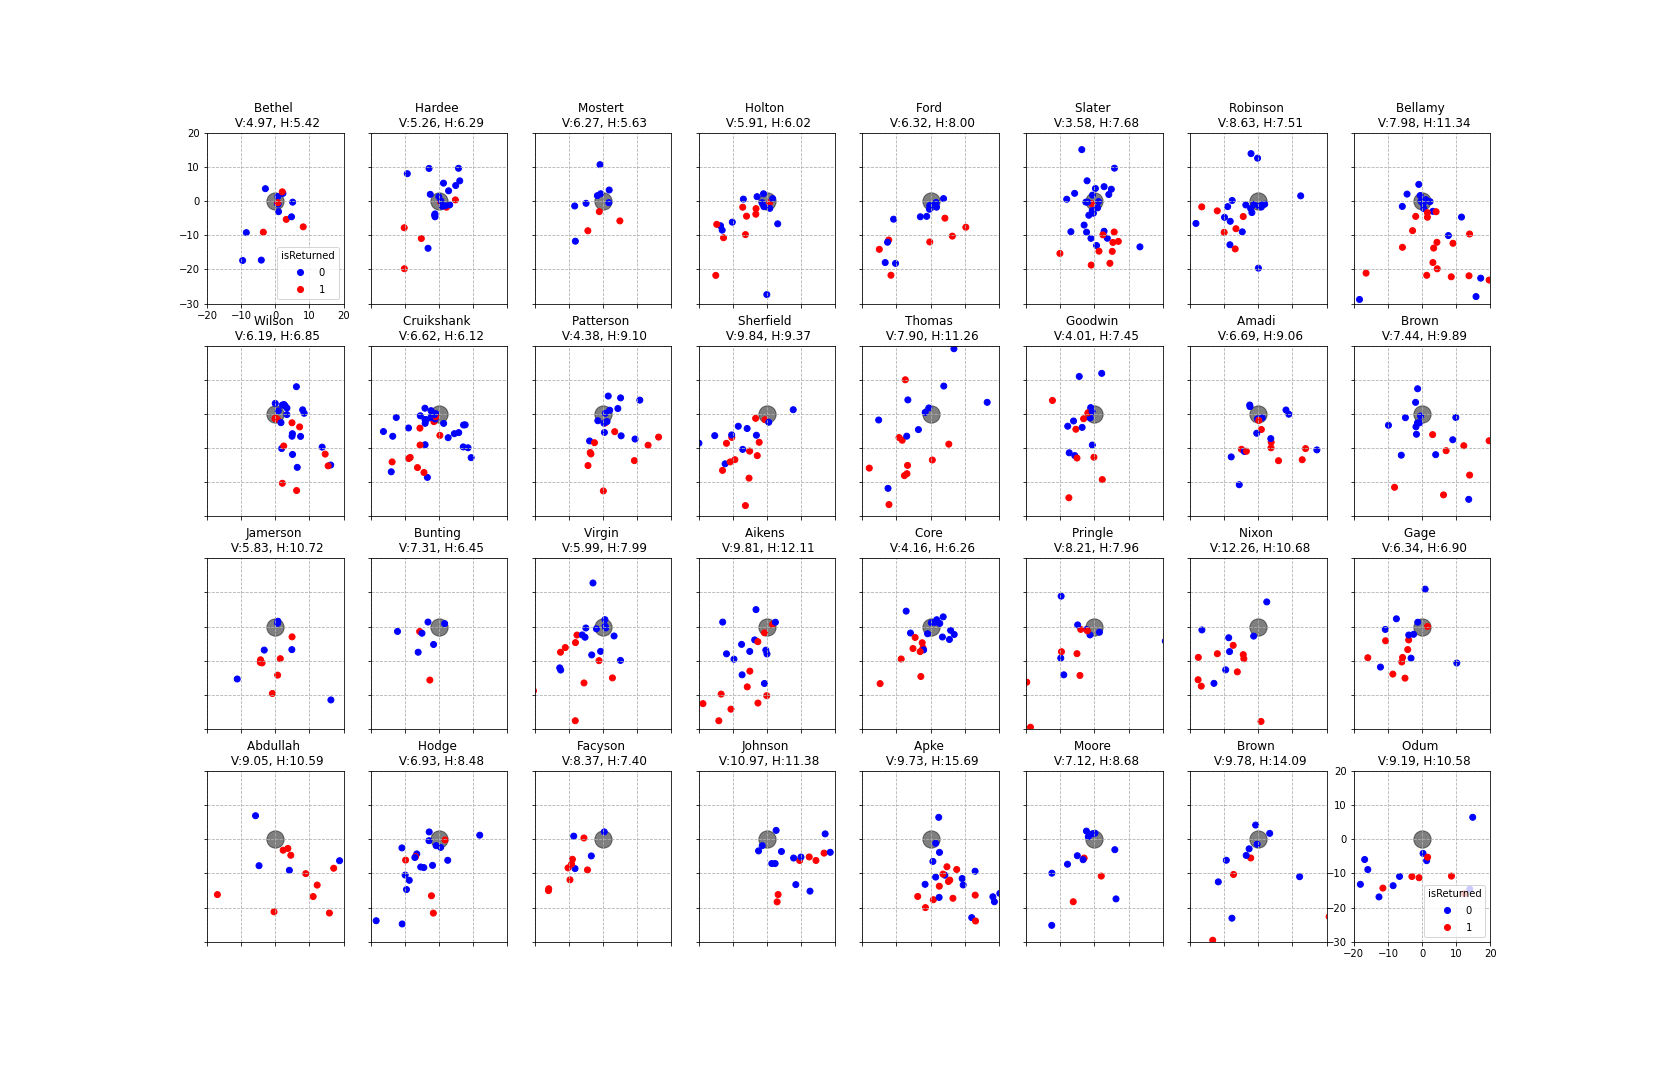

In [7]:
Image(path_data + 'FullReturning.png')

<i>Figure 1: Example play animation with individual coverage</i>

We track $redEPA$ - how much reduction, and $EstimatedEPA$ - the maximum reduction a defender could achieve. **Having a redEPA of 0 would be equivalent to “leaving him open” and having a redEPA equal to EstimatedEPA would be the upper limit of excellent defence.** Hence we will now call  `EstimatedEPA` redEPA oppourtunities or `redEPAOpps`.

The season long percentage of `redEPA percentage = redEPA/redEPAOpps` tells us how efficient a defender is in coverage. Sorted for all defenders in <a href="#3">Section 4.</a> 
  
Finally, the credit of `redEPA = 1.43`  and `redEPAOpps = 3.07` would be split close to half/half between Everett's **main defender** #22(CB, Scandrick) **and help defender** #38(FS, Parker) as they are projected to be the same distance from Everett. In a play with man coverage the main defender will have a higher weight (close to 80%), and the help defender will receive less credit. In poor coverage situations, defenders will receive lots of `redEPAOpps` but little `redEPA` lowering their `redEPA/redEPAOpps` percentage. 



# <h1 id = '3' style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px">3. An Example Play<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#3">¶</a></h1>

The model for **what happens if** the QB throws to a receiver at each frame - which he actually does not - is trained on other completions and incomplete pass of the 2018 season.  

Even though Goff never makes the throw to #81 (TE, Everett) on that play, we know a player would make that reception 80% of the time *if left wide open* and 39% of the time when *covered in a similar manner.*
Furthermore if the catch was made, the model estimates that #81 (TE, Everett) would have gained approximately 19 yards total, producing an EPA of 3.07. 

In [8]:
Video(path_data + "SEA2645OB.mp4")

To calculate catch probability we first calculate the influence of both teams on the field, specifically the defence's influence on each receiver's catchability area, shown in dark dashed circles. **The average influence inside each catchability area is the first input into the catch probability model.**   

Multiple defenders will lead to a greater summed influence and better coverage, this helps address zone coverage and help defence. The parameters to calculate influence and catchability areas have been carefully tuned to NFL Football using kinematics. 

In the following heatmap, red colors show more influence by the receiving team (an open receiver), while green areas show good coverage by the defending team. We will see that: 
  
* #30 (RB, Gurley) has a defender influence of close to 0 - his catchability area is nearly fully red
* #83 (WR, Reynolds) has his catchability area is often green (defender influence 0.7 and above) or white (0.5)

<i>Figure 2: Example play animation team influence and defender coverage</i>

We use a *defender influence of 0* to as the input to catch probability of a wide-open receiver: $OpenCatchProba$. We use the actual defender influence to that receiver to predict the covered catch probability: $CovCatchProba$. 

Recall: $redEPA=(OpenCatchProba−CovCatchProba)	\times EstimatedEPA $
  
*Given various defender influence, ranging from 0 to 1 per Figure 2*, the catch probability for a receiver standing still at each point on the field is shown by the following heatmap. Notice that:

* the position of the receiver greatly affects catch probability, with the quarter back on the right hash mark (these are all inputs into the probability model along with defender influence)
* the velocity, acceleration and orientation of the receiver would affect his catch probability too, not depicted
  
<i>Figure 3: Catch probability given constant defender influence, use dropdowns and scroll right for probability colorbar</i>

With 0.5 defender influence the play is calibrated to be close to a "50/50 ball". However, an excellent 0.95 defender influence still leads to a non-zero probability, these are the highlight reel catches. Nonetheless, reducing catch probability directly reduces EPA, **the greatest reductions are made in the short middle areas between the hash marks.**  

Finally, a similar model made from successful completions in the season to estimate how many total yards a receiver would gain if the ball was caught. This model was heavily inspired by the [2020 Big Data Bowl.](https://www.kaggle.com/c/nfl-big-data-bowl-2020) and uses general football features to avoid overfitting to training data. Note that these models are applied every frame to every receiver, label leakage is a minor concern. 

# <h1 id = "4" style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px ">4. Fire Time<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#4">¶</a></h1>

The calculations for $redEPA$ for the entire season was completed in another notebook[[5]](https://www.kaggle.com/wonkydiamond/nfl-redepa-per-play/). We calculate and track: 
* the total redEPA (`redEpa_sum`) that was reduced, rewarded as the main and help defender. 
* the total redEPA *opportunities* (`redEpaOpps_sum`) while defending.
* total frames spent as the main defender of a positive EPA receiver (`totFramesAsMain_sum`)
* amount of help received as main defender (`avgWeightAsMain`)    
  
  
Higher values in the last two stats indicates a defender being in more isolated coverage situations "on an island". 
  
Efficient coverage means more reducing lots of EPA on limited opportunities. We sort the data on the ratio of `redEPA percentage = redEpa_sum / redEpaOpps_sum`. Players must be in the top 50% of redEPA Opportunities to qualify as it is easy to achieve high redEpa percent on low volume.

# <h1 id = '5' style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px ">5. What are the pros and cons of redEPA?<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#5">¶</a></h1>

The highlighted `redEpaOpps_sum` show defenders who have covered more receiver with high EPA potential throughout the season. Although some Safeties make the top of the list by being excellent in help coverage, it is more impressive to achieve a **season long high redEPA percentage at large volumes** delivering good coverage on many opportunities. We plot with $redEPAOpportunities$ on the $x$ axis: 
<br><br>
<i>Figure 4: redEPA and redEPA opportunities of the 2018 season</i>  

This plot reveals the talented island and shadow cornerbacks who efficiently cover large volumes of high EPA routes over time. Linebackers and safeties trail behind in volume and coverage efficiency yet we are still able to distinguish the top defenders in coverage per position. 

Efficient redEpa defenders tend to cover the best receivers who will be targeted regardless. **We should expect to see a lower completion percentage from strong redEPA defenders** 
Plotting completion percent from Pro Football Reference [[6]](https://www.pro-football-reference.com/years/2018/defense_advanced.htm) with redEPA percent: 
<br><br>
<i>Figure 5: redEPA and completion percent of the 2018 season</i>  

We notice a visible relationship with higher redEPA and lower completion percentage as both indicates good coverage. It appears that the Pro Bowl selections tend to favour players with *low completion percentage* of their position (and other well known stats when targeted). Therefore defenders efficient in $redEPA$ such as <u>Quandre Diggs, Levi Wallace and Darryl Roberts can be considered undervalued in 2018 for their excellent coverage in redEPA.</u> 

# <h1 id = '5' style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px ">6. What are the pros and cons of redEPA?<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#5">¶</a></h1>

<table>
  <tr>
    <td>
      <p><b>Pro: Rewards good coverage in non-target situations</b>
        This was the main motivator for the project.</p>
    </td>
    <td>
      <p><b>Con: Does not account for interceptions, forced incompletions/fumbles and tackling ability</b>
        These are well tracked stats and usually considered for elite defenders. Some defenders intentionally leave a receiver open to “bait” an interception. <i>This is a major EPA shifting play which redEPA does not account for.<i>
      </p>
    </td>
  </tr>
  <tr>
    <td>
      <p><b>Pro: Rewards good coverage and help coverage on dangerous routes</b>
        A cornerback who defends a deep go route solo is rewarded handsomely for taking away a large EPA gain. Multiple defenders reduces catch probability and both are given weighted credit.
      </p>
    </td>
    <td>
      <p><b>Con: Favours man coverage, although zone is not penalized 
        </b>
       Zone defence tries to reduce total yards rather than catch probability by sometimes allowing short completions. While zone defence is not penalized because redEPA/redEPA percent is not tracked while a receiver is in negative EPA, this type of defence does not directly accumulate redEPA in the first few frames.
      </p>
    </td>
  </tr>

  <tr>
    <td>
      <p><b>Pro: Can be presented visually and easily tuned </b>
        The animations presented above show an easy way for teams to evaluate coverage success for each play. Individual parameters of the model, such as factors increasing or decreasing a players influence can be added to account for different scenarios. <i>This should be the primary use of redEPA.<i>
      </p>
    </td>
    <td>
      <p><b>Con: Does not personalize to an individuals abilities/tendencies
        </b>
        Every player is treated the same to produce general football features. A model to predict playmaking abilities and tendencies (eg. of double moves) of each individual would provide more insight. 
      </p>
    </td>
  </tr>

</table>


# <h1 id = 'Appen' style="background-color: #641E16; color: #EE9A81; text-align: center; padding-top: 12px ">Appendix<a class="anchor-link" href="https://www.kaggle.com/wonkydiamond/redepa-quantifying-good-coverage-but-no-throw/notebook#Appen">¶</a></h1>



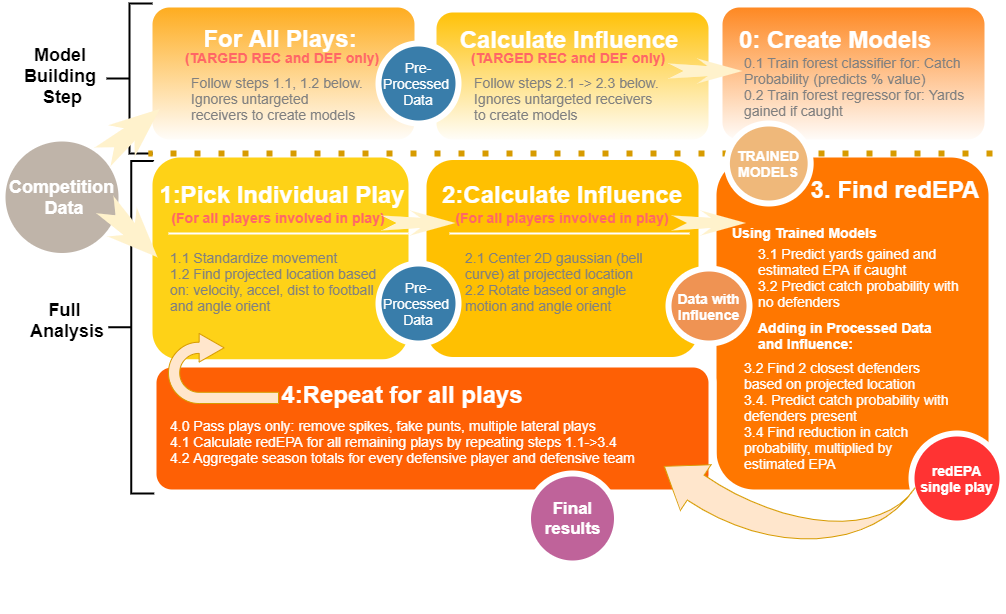